In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
#ROOT.ROOT.EnableImplicitMT()

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.cc","k")

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.cc","k")

Welcome to JupyROOT 6.28/00


In [7]:
def getNumVarsFromCode(code):
    nVars = 0
    while(code > 0):
        nVars += int(code%2)
        code = int(code/2)
    return nVars


def getTotalNumVars(modelName):
    splitted = modelName.split("_")
    numVars = getNumVarsFromCode(int(splitted[1].replace("df", "")))
    numVars += getNumVarsFromCode(int(splitted[2].replace("dl", "")))
    numVars += len(splitted) - 3
    return numVars

modelName="BDTG_df15_dl511_v1_v35"
modelName2="BDTG_df47_dl511_v35"

print(getTotalNumVars(modelName))

s = '''
    TMVA::Experimental::RReader modelScale15("/data/submit/pdmonte/TMVA_models/weightsVars/TMVARegression_{modelName}.weights.xml");
    computeModelScale15 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScale15);
    '''.format(modelName=modelName, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScale15.GetVariableNames())

print(variables, len(variables))

s2 = '''
    TMVA::Experimental::RReader modelScale47("/data/submit/pdmonte/TMVA_models/weightsVars/TMVARegression_{modelName}.weights.xml");
    computeModelScale47 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScale47);
    '''.format(modelName=modelName2, numVarsTotal=getTotalNumVars(modelName2))

ROOT.gInterpreter.ProcessLine(s2)
variables2 = list(ROOT.modelScale47.GetVariableNames())

print(variables2, len(variables2))

15
['goodMeson_eta_input_pred', 'goodMeson_phi_input_pred', 'goodMeson_ditrk_eta_input_pred', 'goodMeson_ditrk_phi_input_pred', 'goodMeson_Nphotons_input_pred', 'goodMeson_photon1_DR_input_pred', 'goodMeson_photon2_DR_input_pred', 'goodPhotons_eta_input_pred', 'goodPhotons_phi_input_pred', 'goodMeson_photon1_pt_input_pred', 'goodMeson_photon2_pt_input_pred', 'goodMeson_ditrk_mass_input_pred', 'goodMeson_mass_input_pred', 'var1_input_pred', 'var35_input_pred'] 15
['goodMeson_eta_input_pred', 'goodMeson_phi_input_pred', 'goodMeson_ditrk_eta_input_pred', 'goodMeson_ditrk_phi_input_pred', 'goodMeson_Nphotons_input_pred', 'goodMeson_photon1_DR_input_pred', 'goodMeson_photon2_DR_input_pred', 'goodPhotons_eta_input_pred', 'goodPhotons_phi_input_pred', 'goodMeson_photon1_pt_input_pred', 'goodMeson_photon2_pt_input_pred', 'goodMeson_ditrk_mass_input_pred', 'goodMeson_mass_input_pred', 'goodMeson_ditrk_pt_input_pred', 'var35_input_pred'] 15


In [10]:
date = "JUL31"

chainSGN = ROOT.TChain("events")
#chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1038_GFcat_OmegaCat_2018.root".format(date))
chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1039_GFcat_Phi3Cat_2018.root".format(date))
#chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1040_GFcat_D0StarRhoCat_2018.root".format(date))
#chainSGN.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc1041_GFcat_D0StarCat_2018.root".format(date))

chainBKG = ROOT.TChain("events")
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc10_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc11_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc12_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc13_GFcat_Phi3Cat_2018.root".format(date))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc14_GFcat_Phi3Cat_2018.root".format(date))

dfSGN = ROOT.RDataFrame(chainSGN)
dfSGN = (dfSGN.Define("scale", "w*lumiIntegrated")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScale15, variables)
        .Define("scaleFactor2", ROOT.computeModelScale47, variables2)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("goodMeson_pt_PRED2", "scaleFactor2[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("HCandMass_varPRED2", "compute_HiggsVars_var(goodMeson_pt_PRED2, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

dfBKG = ROOT.RDataFrame(chainBKG)
dfBKG = (dfBKG.Define("scale", "w*lumiIntegrated")
        .Define("scaleFactor", ROOT.computeModelScale15, variables)
        .Define("scaleFactor2", ROOT.computeModelScale47, variables2)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("goodMeson_pt_PRED2", "scaleFactor2[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("HCandMass_varPRED2", "compute_HiggsVars_var(goodMeson_pt_PRED2, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
        

cols = ["goodMeson_pt", "goodMeson_pt_GEN", "goodMeson_pt_PRED", "scaleFactor"]
x = dfSGN.AsNumpy(columns=cols)
pddf_SGN = pd.DataFrame(x)
#display(pddf_SGN)

goodMesonDiffReco = [x[0] for x in pddf_SGN["goodMeson_pt"].values] - pddf_SGN["goodMeson_pt_GEN"].values
goodMesonDiffPred = pddf_SGN["goodMeson_pt_PRED"].values - pddf_SGN["goodMeson_pt_GEN"].values
errorMesonReco = np.sqrt(np.mean(goodMesonDiffReco**2))
errorMesonPred = np.sqrt(np.mean(goodMesonDiffPred**2))
#print("RecoMeson:\t {:.9f}\t\tPredMeson:\t {:.9f}".format(round(errorMesonReco, 9), round(errorMesonPred, 9)))

cols = ["goodMeson_pt", "goodMeson_pt_PRED", "scaleFactor"]
x = dfBKG.AsNumpy(columns=cols)
pddf_BKG = pd.DataFrame(x)
#display(pddf_BKG)


RECO 117-133:	 21086.85587254765
PRED 117-133:	 26359.671228471176  + 25.0 %
PRED2 117-133:	 26447.782251368022  + 25.4 %


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


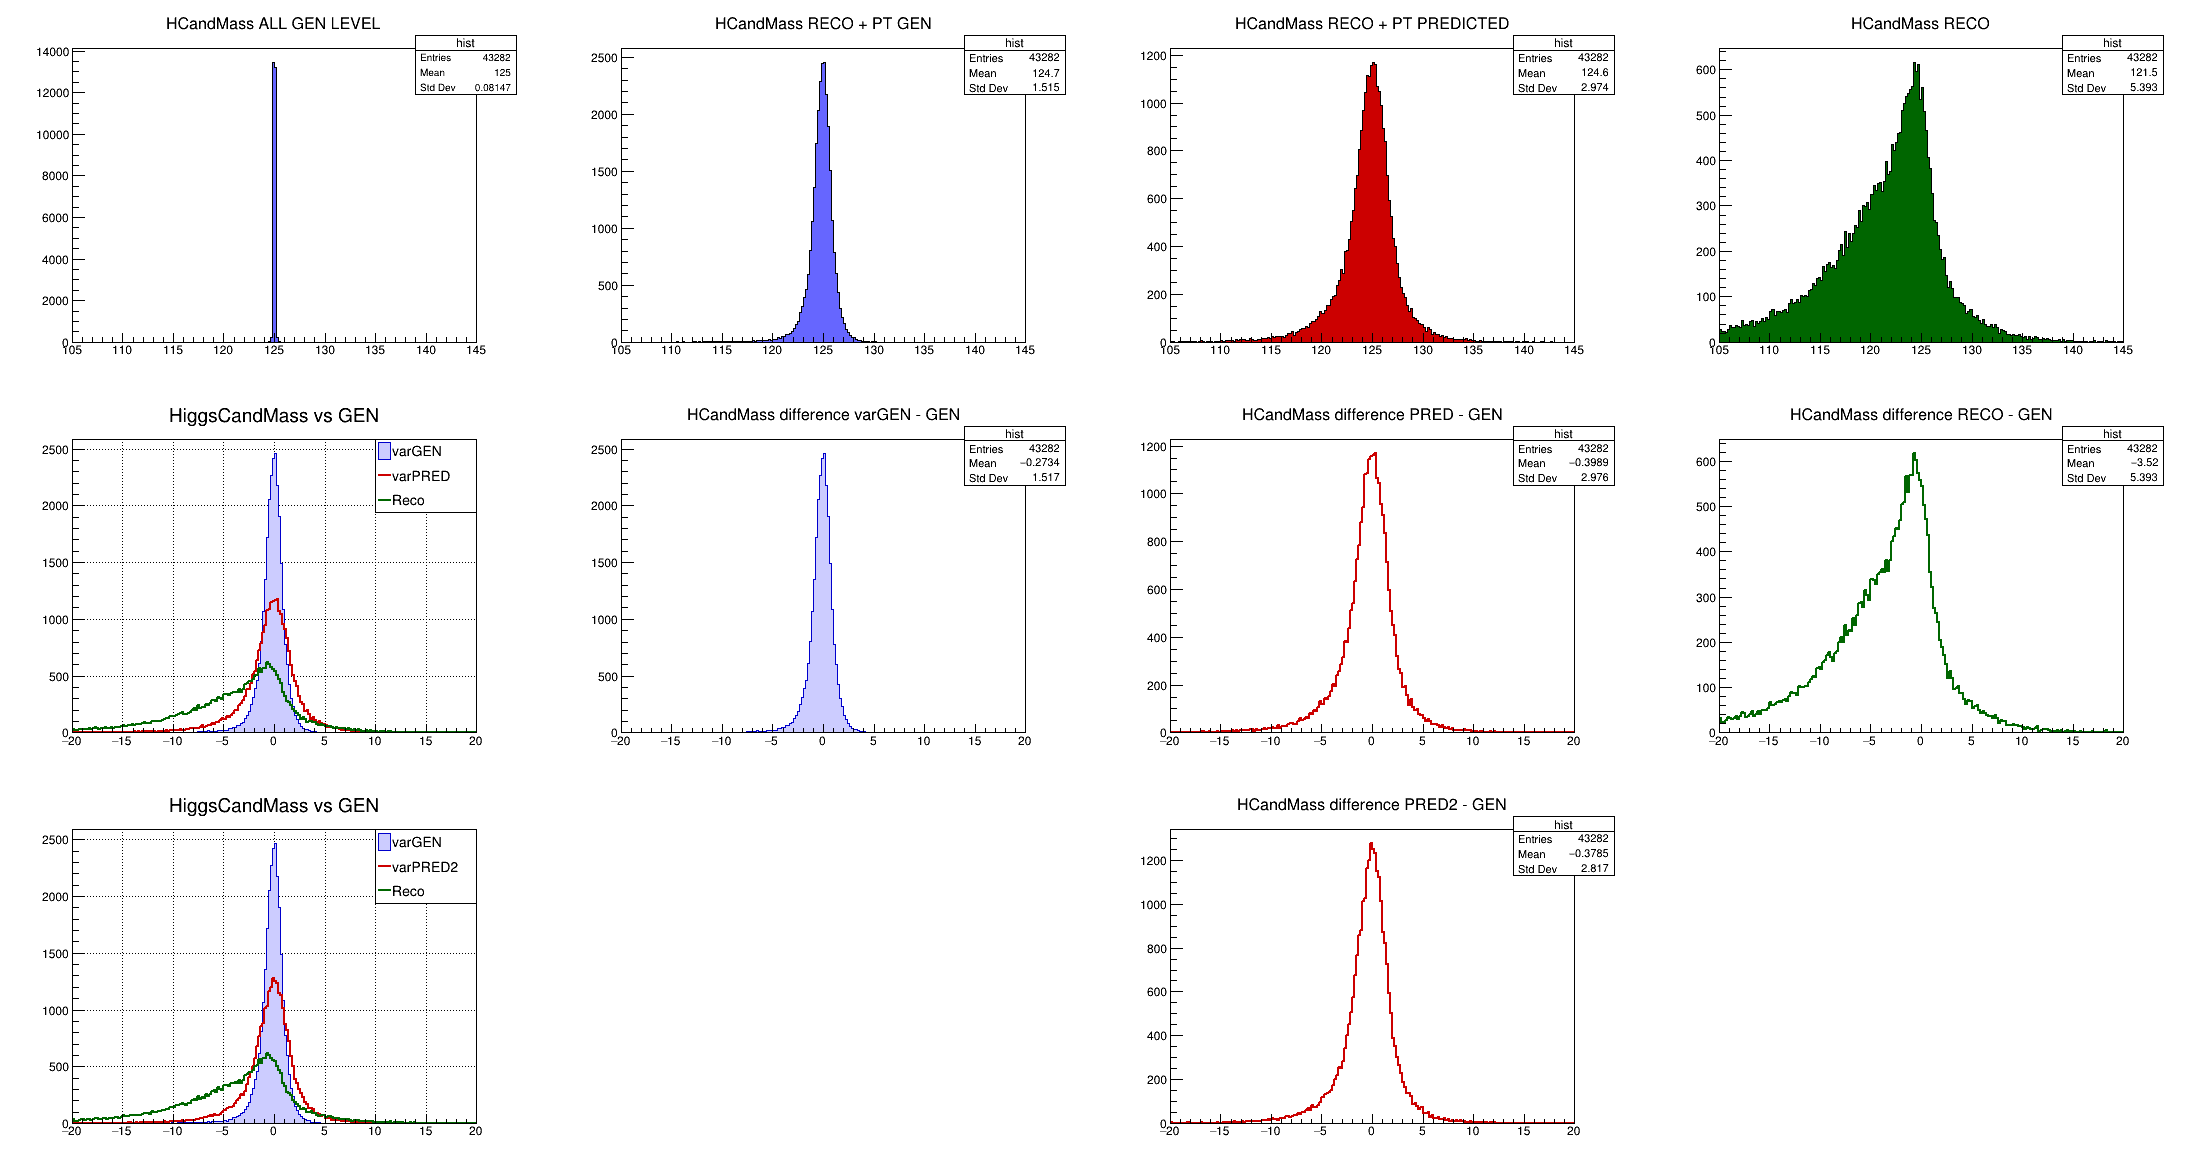

In [26]:
canvas = ROOT.TCanvas("canvas", "canvas", 2200, 1200)
canvas.Divide(4, 3)

nbins, xlow, xhigh = 200, 105, 145
xlowdiff, xhighdiff = -20, 20

h1 = dfSGN.Histo1D(("hist", "HCandMass ALL GEN LEVEL", nbins, xlow, xhigh), "HCandMass_GEN", "scale")
h2 = dfSGN.Histo1D(("hist", "HCandMass RECO + PT GEN", nbins, xlow, xhigh), "HCandMass_varGEN", "scale")
h3 = dfSGN.Histo1D(("hist", "HCandMass RECO + PT PREDICTED", nbins, xlow, xhigh), "HCandMass_varPRED", "scale")
h32 = dfSGN.Histo1D(("hist", "HCandMass RECO + PT PREDICTED2", nbins, xlow, xhigh), "HCandMass_varPRED2", "scale")
h4 = dfSGN.Histo1D(("hist", "HCandMass RECO", nbins, xlow, xhigh), "HCandMass", "scale")

h6 = dfSGN.Define("good", "HCandMass_varGEN - HCandMass_GEN").Histo1D(("hist", "HCandMass difference varGEN - GEN", nbins, xlowdiff, xhighdiff), "good", "scale")
h7 = dfSGN.Define("good", "HCandMass_varPRED - HCandMass_GEN").Histo1D(("hist", "HCandMass difference PRED - GEN", nbins, xlowdiff, xhighdiff), "good", "scale")
h72 = dfSGN.Define("good", "HCandMass_varPRED2 - HCandMass_GEN").Histo1D(("hist", "HCandMass difference PRED2 - GEN", nbins, xlowdiff, xhighdiff), "good", "scale")
h8 = dfSGN.Define("good", "HCandMass - HCandMass_GEN").Histo1D(("hist", "HCandMass difference RECO - GEN", nbins, xlowdiff, xhighdiff), "good", "scale")


h1.SetFillColor(ROOT.kBlue-7)
h1.SetLineColor(ROOT.kBlack)
h2.SetFillColor(ROOT.kBlue-7)
h2.SetLineColor(ROOT.kBlack)
h3.SetFillColor(ROOT.kRed+1)
h3.SetLineColor(ROOT.kBlack)
h4.SetFillColor(ROOT.kGreen+3)
h4.SetLineColor(ROOT.kBlack)

h6.SetLineColor(ROOT.kBlue+1)
h6.SetFillColor(ROOT.kBlue-10)
h7.SetLineColor(ROOT.kRed+1)
h8.SetLineColor(ROOT.kGreen+3)
h6.SetLineWidth(1)
h7.SetLineWidth(2)
h8.SetLineWidth(2)

h72.SetLineColor(ROOT.kRed+1)
h72.SetLineWidth(2)


p = canvas.cd(1)
h1.Draw("hist")
p = canvas.cd(2)
h2.Draw("hist")
p = canvas.cd(3)
h3.Draw("hist")
p = canvas.cd(4)
h4.Draw("hist")

p = canvas.cd(6)
h6.Draw("hist")
p = canvas.cd(7)
h7.Draw("hist")
p = canvas.cd(8)
h8.Draw("hist")

p = canvas.cd(11)
h72.Draw("hist")

p = canvas.cd(5)
stack = ROOT.THStack("stack", "HiggsCandMass vs GEN")
stack.Add(h6.GetValue())
stack.Add(h7.GetValue())
stack.Add(h8.GetValue())
stack.Draw("hist nostack")
legend = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend.SetMargin(0.17)
#legend.SetBorderSize(0)
legend.SetTextSize(0.04)
legend.AddEntry(h6.GetValue(), "varGEN", "f")
legend.AddEntry(h7.GetValue(), "varPRED", "l")
legend.AddEntry(h8.GetValue(), "Reco", "l")
legend.Draw()
p.SetGrid()

p = canvas.cd(9)
stack2 = ROOT.THStack("stack", "HiggsCandMass vs GEN")
stack2.Add(h6.GetValue())
stack2.Add(h72.GetValue())
stack2.Add(h8.GetValue())
stack2.Draw("hist nostack")
legend2 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend2.SetMargin(0.17)
#legend.SetBorderSize(0)
legend2.SetTextSize(0.04)
legend2.AddEntry(h6.GetValue(), "varGEN", "f")
legend2.AddEntry(h72.GetValue(), "varPRED2", "l")
legend2.AddEntry(h8.GetValue(), "Reco", "l")
legend2.Draw()
p.SetGrid()
canvas.Draw()

NSig_reco = h4.Integral(h4.FindBin(117), h4.FindBin(133))
NSig_pred = h3.Integral(h3.FindBin(117), h3.FindBin(133))
NSig_pred2 = h32.Integral(h32.FindBin(117), h32.FindBin(133))

print("RECO 117-133:\t", NSig_reco)
print("PRED 117-133:\t", NSig_pred, " +", round((NSig_pred/NSig_reco - 1)*100, 1), "%")
print("PRED2 117-133:\t", NSig_pred2, " +", round((NSig_pred2/NSig_reco - 1)*100, 1), "%")

STD RECO:	 5.952933768182524
STD PRED:	 3.2784684385870104   -44.9 %
STD PRED2:	 3.1241799741076206   -47.5 %


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


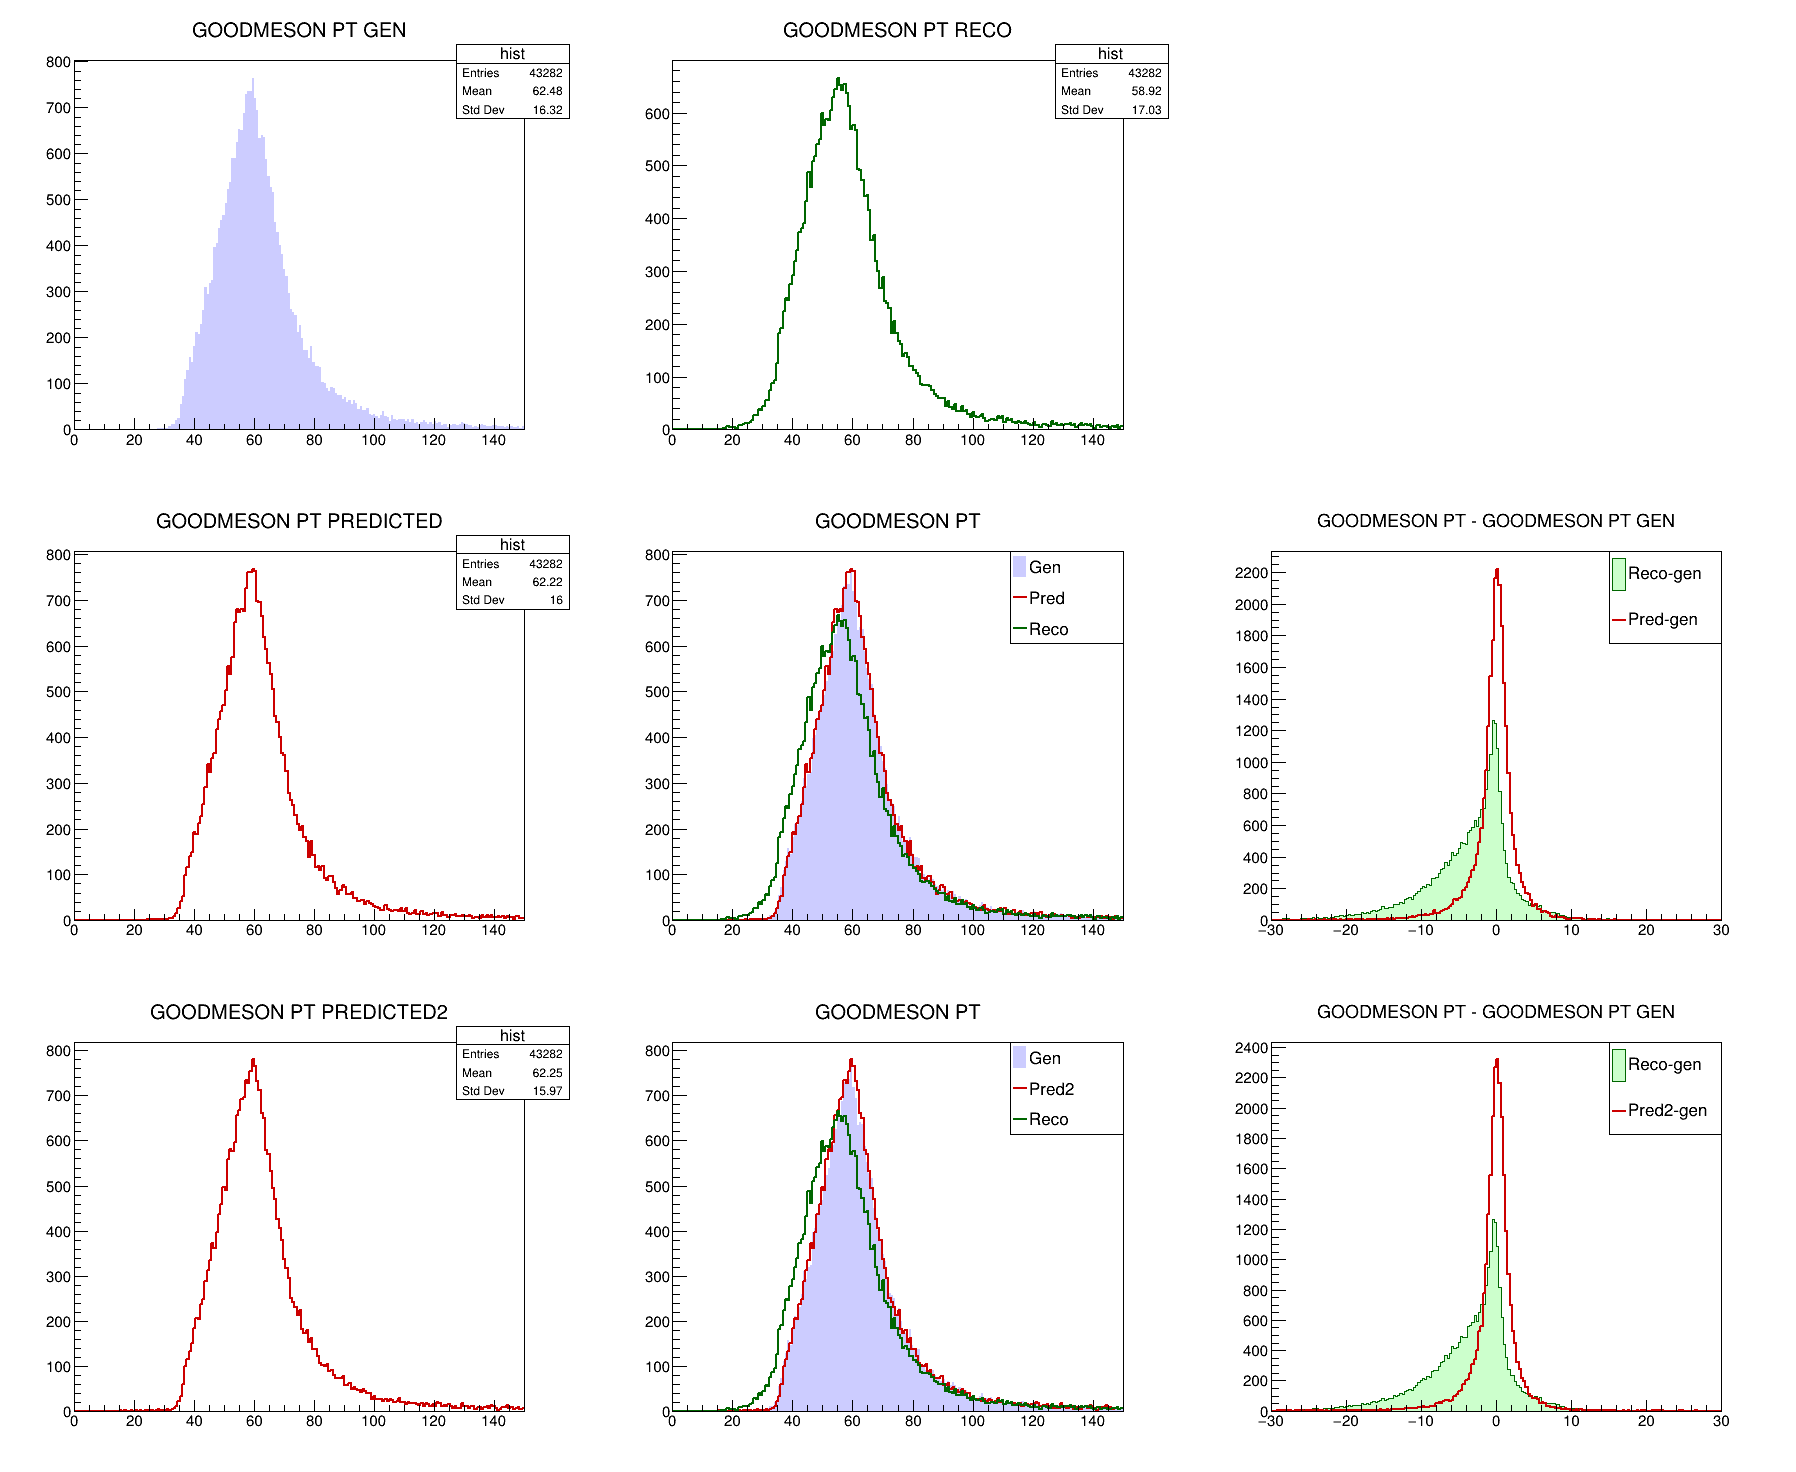

In [27]:
canvas = ROOT.TCanvas("canvas", "canvas", 1800, 1500)
canvas.Divide(3, 3)

nbins, xlow, xhigh = 200, 0, 150
xlowdiff, xhighdiff = -30, 30

h1 = dfSGN.Histo1D(("hist", "GOODMESON PT GEN", nbins, xlow, xhigh), "goodMeson_pt_GEN", "scale")
h2 = dfSGN.Histo1D(("hist", "GOODMESON PT PREDICTED", nbins, xlow, xhigh), "goodMeson_pt_PRED", "scale")
h22 = dfSGN.Histo1D(("hist", "GOODMESON PT PREDICTED2", nbins, xlow, xhigh), "goodMeson_pt_PRED2", "scale")
h3 = dfSGN.Histo1D(("hist", "GOODMESON PT RECO", nbins, xlow, xhigh), "goodMeson_pt", "scale")
h5_1 = dfSGN.Define("good", "goodMeson_pt - goodMeson_pt_GEN").Histo1D(("hist", "RECO - GEN", nbins, xlowdiff, xhighdiff), "good", "scale")
h5_2 = dfSGN.Define("good", "goodMeson_pt_PRED - goodMeson_pt_GEN").Histo1D(("hist", "PRED - GEN", nbins, xlowdiff, xhighdiff), "good", "scale")
h5_22 = dfSGN.Define("good", "goodMeson_pt_PRED2 - goodMeson_pt_GEN").Histo1D(("hist", "PRED2 - GEN", nbins, xlowdiff, xhighdiff), "good", "scale")

h1.SetLineColor(ROOT.kBlue+1)
h1.SetFillColor(ROOT.kBlue-10)
h1.SetLineWidth(0)
h2.SetLineColor(ROOT.kRed+1)
h2.SetLineWidth(2)
h22.SetLineColor(ROOT.kRed+1)
h22.SetLineWidth(2)

h3.SetLineColor(ROOT.kGreen+3)
h3.SetLineWidth(2)
h5_2.SetLineColor(ROOT.kRed+1)
h5_2.SetLineWidth(2)
h5_22.SetLineColor(ROOT.kRed+1)
h5_22.SetLineWidth(2)
h5_1.SetLineColor(ROOT.kGreen+3)
h5_1.SetFillColor(ROOT.kGreen-10)
h5_1.SetLineWidth(1)

p = canvas.cd(1)
h1.Draw("hist")
p = canvas.cd(2)
h3.Draw("hist")

p = canvas.cd(4)
h2.Draw("hist")

p = canvas.cd(5)
stack = ROOT.THStack("stack", "GOODMESON PT")
stack.Add(h1.GetValue())
stack.Add(h2.GetValue())
stack.Add(h3.GetValue())
stack.Draw("hist nostack")
legend = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend.SetMargin(0.17)
#legend.SetBorderSize(0)
legend.SetTextSize(0.04)
legend.AddEntry(h1.GetValue(), "Gen", "f")
legend.AddEntry(h2.GetValue(), "Pred", "l")
legend.AddEntry(h3.GetValue(), "Reco", "l")
legend.Draw()

p = canvas.cd(6)
stack2 = ROOT.THStack("stack", "GOODMESON PT - GOODMESON PT GEN")
stack2.Add(h5_1.GetValue())
stack2.Add(h5_2.GetValue())
stack2.Draw("hist nostack")
legend2 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend2.SetMargin(0.17)
#legend.SetBorderSize(0)
legend2.SetTextSize(0.04)
legend2.AddEntry(h5_1.GetValue(), "Reco-gen", "f")
legend2.AddEntry(h5_2.GetValue(), "Pred-gen", "l")
legend2.Draw()


p = canvas.cd(7)
h22.Draw("hist")

p = canvas.cd(8)
stack3 = ROOT.THStack("stack", "GOODMESON PT")
stack3.Add(h1.GetValue())
stack3.Add(h22.GetValue())
stack3.Add(h3.GetValue())
stack3.Draw("hist nostack")
legend3 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend3.SetMargin(0.17)
#legend.SetBorderSize(0)
legend3.SetTextSize(0.04)
legend3.AddEntry(h1.GetValue(), "Gen", "f")
legend3.AddEntry(h22.GetValue(), "Pred2", "l")
legend3.AddEntry(h3.GetValue(), "Reco", "l")
legend3.Draw()

p = canvas.cd(9)
stack4 = ROOT.THStack("stack", "GOODMESON PT - GOODMESON PT GEN")
stack4.Add(h5_1.GetValue())
stack4.Add(h5_22.GetValue())
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
#legend.SetBorderSize(0)
legend4.SetTextSize(0.04)
legend4.AddEntry(h5_1.GetValue(), "Reco-gen", "f")
legend4.AddEntry(h5_22.GetValue(), "Pred2-gen", "l")
legend4.Draw()

canvas.Draw()
print("STD RECO:\t", h5_1.GetValue().GetStdDev())
print("STD PRED:\t", h5_2.GetValue().GetStdDev(), " ", round((h5_2.GetValue().GetStdDev()/h5_1.GetValue().GetStdDev() - 1)*100, 1), "%")
print("STD PRED2:\t", h5_22.GetValue().GetStdDev(), " ", round((h5_22.GetValue().GetStdDev()/h5_1.GetValue().GetStdDev() - 1)*100, 1), "%")

RECO 117-133:	 13411.563844420092
PRED 117-133:	 14086.15159908354  + 5.0 %
PRED2 117-133:	 23327.883507072103  + 73.9 %
Maximize RECO:	 182.0841398832793
Maximize PRED:	 222.09757167248173  + 22.0 %
Maximize PRED2:	 173.16160066690807  + -4.9 %


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


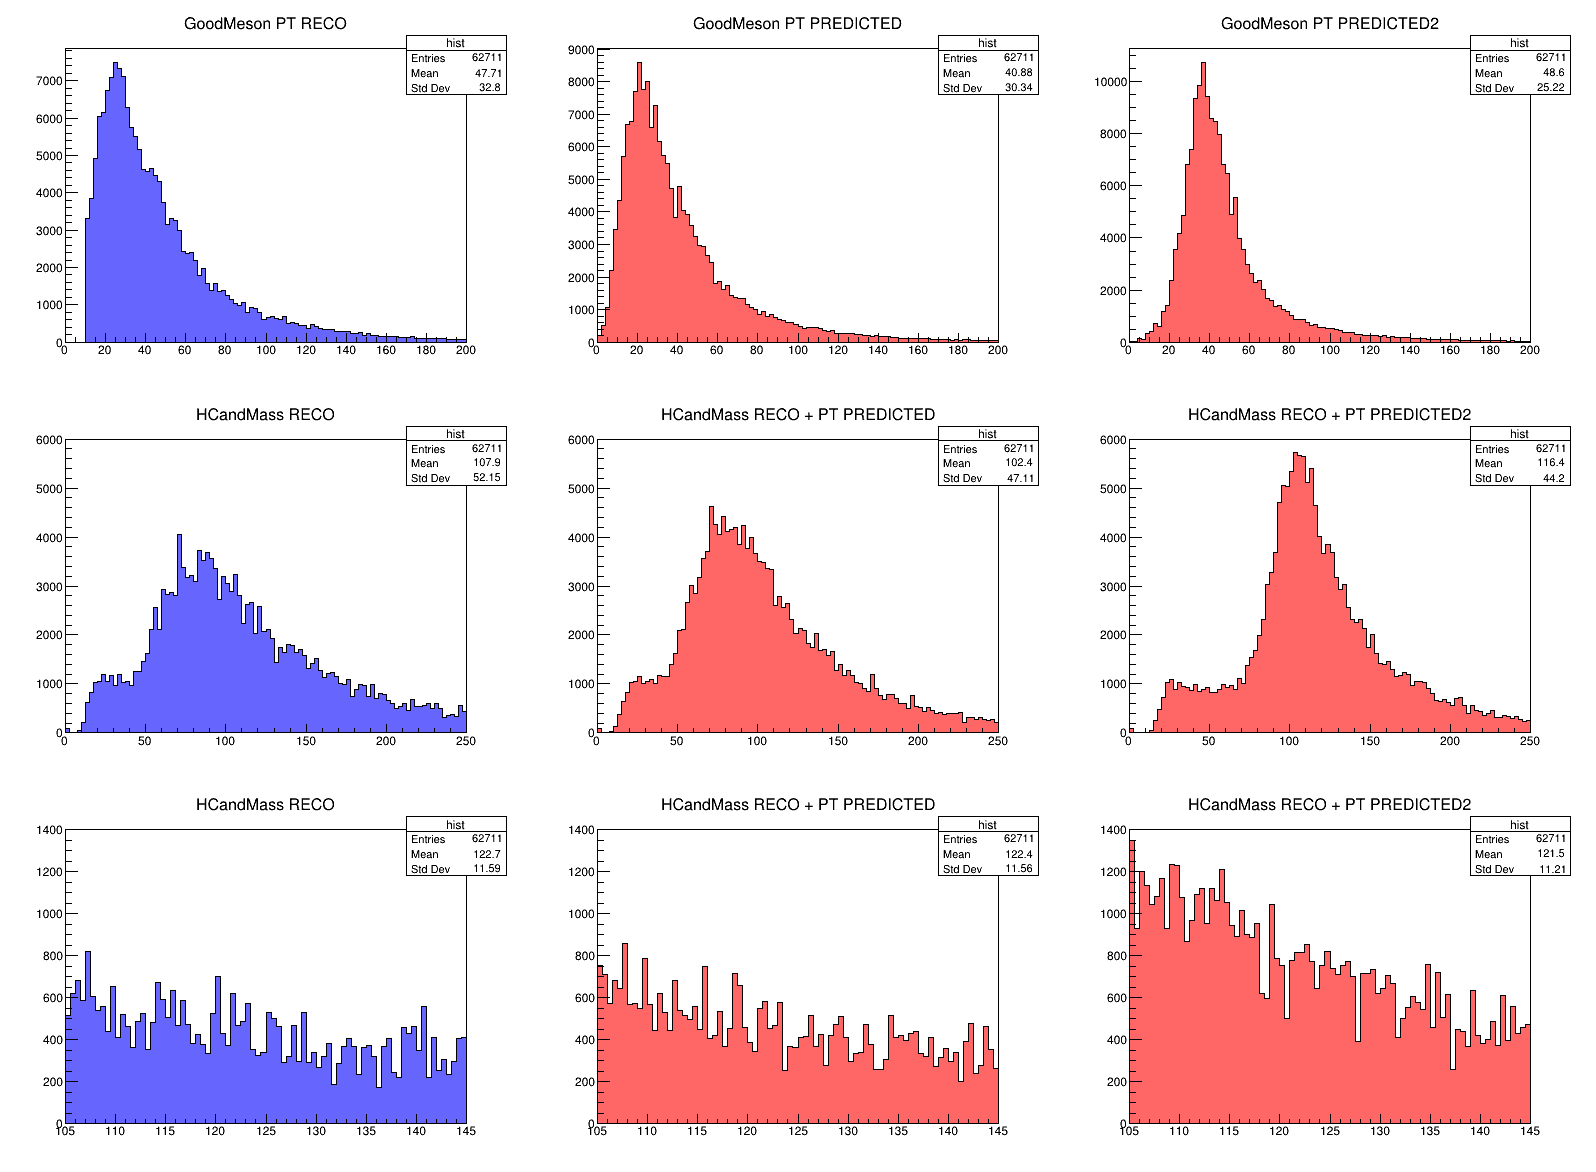

In [28]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 1200)
canvas.Divide(3, 3)

nbins, xlow, xhigh = 100, 0, 200
xlowdiff, xhighdiff = 0, 250

h1 = dfBKG.Histo1D(("hist", "GoodMeson PT RECO", nbins, xlow, xhigh), "goodMeson_pt", "scale")
h2 = dfBKG.Histo1D(("hist", "GoodMeson PT PREDICTED", nbins, xlow, xhigh), "goodMeson_pt_PRED", "scale")
h22 = dfBKG.Histo1D(("hist", "GoodMeson PT PREDICTED2", nbins, xlow, xhigh), "goodMeson_pt_PRED2", "scale")

h3 = dfBKG.Histo1D(("hist", "HCandMass RECO", nbins, xlowdiff, xhighdiff), "HCandMass", "scale")
h4 = dfBKG.Histo1D(("hist", "HCandMass RECO + PT PREDICTED", nbins, xlowdiff, xhighdiff), "HCandMass_varPRED", "scale")
h42 = dfBKG.Histo1D(("hist", "HCandMass RECO + PT PREDICTED2", nbins, xlowdiff, xhighdiff), "HCandMass_varPRED2", "scale")
nbins, xlowdiff, xhighdiff = 80, 105, 145
h5 = dfBKG.Histo1D(("hist", "HCandMass RECO", nbins, xlowdiff, xhighdiff), "HCandMass", "scale")
h6 = dfBKG.Histo1D(("hist", "HCandMass RECO + PT PREDICTED", nbins, xlowdiff, xhighdiff), "HCandMass_varPRED", "scale")
h62 = dfBKG.Histo1D(("hist", "HCandMass RECO + PT PREDICTED2", nbins, xlowdiff, xhighdiff), "HCandMass_varPRED2", "scale")

h5.SetMinimum(0)
h6.SetMinimum(0)
h62.SetMinimum(0)

h5.SetMaximum(1400)
h6.SetMaximum(1400)
h62.SetMaximum(1400)

h3.SetMaximum(6000)
h4.SetMaximum(6000)
h42.SetMaximum(6000)

h1.SetFillColor(ROOT.kBlue-7)
h1.SetLineColor(ROOT.kBlack)
h2.SetFillColor(ROOT.kRed-7)
h2.SetLineColor(ROOT.kBlack)
h22.SetFillColor(ROOT.kRed-7)
h22.SetLineColor(ROOT.kBlack)
h3.SetFillColor(ROOT.kBlue-7)
h3.SetLineColor(ROOT.kBlack)
h4.SetFillColor(ROOT.kRed-7)
h4.SetLineColor(ROOT.kBlack)
h42.SetFillColor(ROOT.kRed-7)
h42.SetLineColor(ROOT.kBlack)
h5.SetFillColor(ROOT.kBlue-7)
h5.SetLineColor(ROOT.kBlack)
h6.SetFillColor(ROOT.kRed-7)
h6.SetLineColor(ROOT.kBlack)
h62.SetFillColor(ROOT.kRed-7)
h62.SetLineColor(ROOT.kBlack)


p = canvas.cd(1)
h1.Draw("hist")
p = canvas.cd(2)
h2.Draw("hist")
p = canvas.cd(3)
h22.Draw("hist")

p = canvas.cd(4)
h3.Draw("hist")
p = canvas.cd(5)
h4.Draw("hist")
p = canvas.cd(6)
h42.Draw("hist")

p = canvas.cd(7)
h5.Draw("hist")
p = canvas.cd(8)
h6.Draw("hist")
p = canvas.cd(9)
h62.Draw("hist")

canvas.Draw()

NBkg_reco = h5.Integral(h5.FindBin(117), h5.FindBin(133))
NBkg_pred = h6.Integral(h6.FindBin(117), h6.FindBin(133))
NBkg_pred2 = h62.Integral(h62.FindBin(117), h62.FindBin(133))

print("RECO 117-133:\t", NBkg_reco)
print("PRED 117-133:\t", NBkg_pred, " +", round((NBkg_pred/NBkg_reco - 1)*100, 1), "%")
print("PRED2 117-133:\t", NBkg_pred2, " +", round((NBkg_pred2/NBkg_reco - 1)*100, 1), "%")

eff_reco = NSig_reco/np.sqrt(NBkg_reco)
eff_pred = NSig_pred/np.sqrt(NBkg_pred)
eff_pred2 = NSig_pred2/np.sqrt(NBkg_pred2)

print("Maximize RECO:\t", eff_reco)
print("Maximize PRED:\t", eff_pred, " +", round((eff_pred/eff_reco - 1)*100, 1), "%")
print("Maximize PRED2:\t", eff_pred2, " +", round((eff_pred2/eff_reco - 1)*100, 1), "%")